---
# Fix ATB oil attribution
---

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

In [1]:
import sys
import yaml
import pathlib
import numpy
import pandas
import matplotlib.pyplot as plt
import os
import warnings
from dask import delayed
from monte_carlo_utils import make_bins, get_bin, place_into_bins

In [2]:
oil_attrs_path = pathlib.Path('/data/MIDOSS/marine_transport_data/')
with open(oil_attrs_path/'oil_attribution.yaml') as file:
      oil_attrs = yaml.safe_load(file)

In [3]:
#~~~ atb traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fuel and cargo capacity information
# K: "Vessel length (AIS)"
# L: "Vessel Length (AIS + <50 m correction)"
# O: "Total Fuel Capacity (liters)"
# P: "Cargo Capacity (liters)"

atb_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='atb', 
    usecols='K,L,O,P',
    skiprows=1
)
# create line fit for atbs with length > 50 m
# fit = coefficient[1] + coefficient[0] * length
good_values = atb_df['Vessel Length (AIS + <50 m correction)']>0
atb_exp_coefs = numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    numpy.log(atb_df['Cargo Capacity (liters)'][good_values]), 
    1
)
atb_line_coefs = numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    atb_df['Cargo Capacity (liters)'][good_values], 
    1
)
atb_quad_coefs = numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    atb_df['Cargo Capacity (liters)'][good_values], 
    2
)

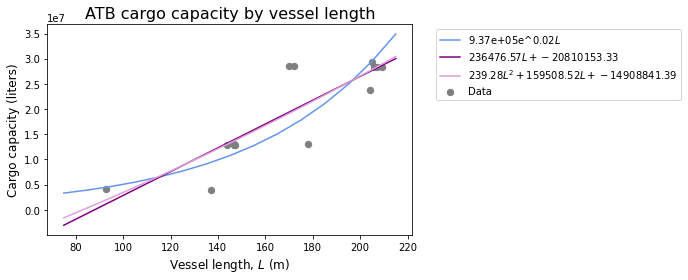

In [4]:
########### PLOT ATB DATA FIT ###############
atb_length = numpy.arange(75, 225, 10)
# fit exponential curve
C = atb_exp_coefs
atb_fit = (
    numpy.exp(C[1]) * 
    numpy.exp(C[0]*atb_length)
)
# fit line
Cl = atb_line_coefs
atb_line_fit = (
    Cl[1]+
    Cl[0]*atb_length
)
# fit quadratic curve
Cq = atb_quad_coefs
atb_quad_fit = (
    Cq[2]+
    Cq[1]*atb_length+
    Cq[0]*atb_length**2
)
fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
#length = atb_df['Vessel Length (AIS + <50 m correction)']
good_data = atb_df['Vessel Length (AIS + <50 m correction)']>0
ax1.scatter(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values],
    atb_df['Cargo Capacity (liters)'][good_values],
    40,
    label='Data',
    color='tab:grey'
)

ax1.plot(
    atb_length, 
    atb_fit, 
    c='cornflowerblue', 
    label=f'{numpy.exp(C[1]):.02e}e^{C[0]:.02f}$L$'
)
ax1.plot(
    atb_length, 
    atb_line_fit, 
    c='purple', 
    label=f'${Cl[0]:.02f}L + {Cl[1]:.02f}$'
)
ax1.plot(
    atb_length, 
    atb_quad_fit, 
    c='plum', 
    label=f'${Cq[0]:.02f}L^2 + {Cq[1]:.02f}L + {Cq[2]:.02f}$'
)

plt.xlabel('Vessel length, $L$ (m)',fontsize=12)
plt.ylabel('Cargo capacity (liters)',fontsize=12)
plt.title('ATB cargo capacity by vessel length', fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'cargo_fit.png', bbox_inches='tight')
plt.show()

#### Choosing a linear fit

## Find ATBs > 50m and assign corrected cargo_capacities
I copied the ordered monte_carlo spills file with spills < 3 L removed to a new file called `SalishSea_oil_spills_corrected.csv` and modify this copied file

In [5]:
# fit line
C = atb_line_coefs

In [6]:
# spills = '/ocean/rmueller/MIDOSS/spill_files_091921/'\
#          'chosen_for_monte_carlo/SalishSea_oil_spills_corrected.csv'
spills = '/ocean/rmueller/MIDOSS/spill_files_091921/'\
         'chosen_for_monte_carlo/SalishSea_oil_spills_corrected_24mar2022.csv'

In [37]:
spills_df = pandas.read_csv(spills,index_col=[0])

In [39]:
spills_df.loc[spills_df.spill_volume<3]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_BP


In [9]:
spills_df.head(2)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_BP
0,2018-02-03 22:00,7,-122.768738,48.858200,245,573,atb,209,366341000,BP Cherry Point Refinery,Chevron Stanovan,106150.674583,2.861345e+06,5307.533729,fuel,Lagrangian_bunker.dat,0.849564
1,2017-08-30 18:00,7,-122.763926,48.868556,244,574,barge,40,366866930,BP Cherry Point Refinery,BP Cherry Point Refinery,306160.614586,3.000000e+06,82663.365938,fuel,Lagrangian_bunker.dat,0.934545


In [10]:
spills_df_new = spills_df.copy()

In [11]:
spills_df_new.loc[
    (spills_df_new.vessel_type == 'atb') &
     (spills_df_new.vessel_len>50), 
    'cargo_capacity'] = C[1]+C[0]*spills_df_new.vessel_len

#### Plot corrected cargo capacities for ATBs > 50m 

In [12]:
atb_spills = spills_df_new.loc[
    (spills_df_new.vessel_type == 'atb')&
     (spills_df_new.vessel_len>50)]

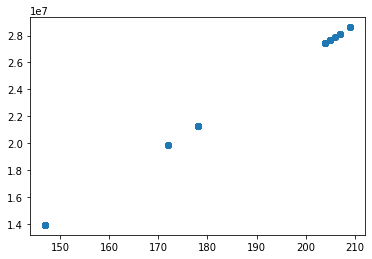

In [13]:
plt.scatter(atb_spills.vessel_len,atb_spills.cargo_capacity)

##### Good!  That looks much better!  :-)

### Apply spill fraction to yield spill volume 

In [14]:
def _cumulative_spill_fraction(fraction):
    """Calculate the cumulative spill probability up to fraction based on 10 spill cases from Ryah.
    :param fraction: Spill fraction.
    :type fraction: :py:class:`numpy.ndarray`
    :return: Cumulative spill probability.
    :rtype: :py:class:`numpy.ndarray`
    """
    typeonefrac = 0.7
    typetwofrac = 1 - typeonefrac
    typeonedec = 28 / 100
    typetwodec = 2 / 100
    multiplier = 1 / (
        1
        - typeonefrac * numpy.exp(-1 / typeonedec)
        - typetwofrac * numpy.exp(-1 / typetwodec)
    )
    return (
        1
        - typeonefrac * numpy.exp(-fraction / typeonedec)
        - typetwofrac * numpy.exp(-fraction / typetwodec)
    ) * multiplier

In [15]:
# Initialize PCG-64 random number generator
random_generator = numpy.random.default_rng(None)
nbins = 50
# We need both sides of the bins, so array is nbins+1 long
fraction = numpy.linspace(0, 1, num=nbins + 1)
cumulative = _cumulative_spill_fraction(fraction)

probability = cumulative[1:] - cumulative[:-1]
central_value = 0.5 * (fraction[1:] + fraction[:-1])

In [16]:
for i in 0,1,2,3:
    spill_fraction = random_generator.choice(central_value, p=probability)
    print(spill_fraction)

0.07
0.01
0.03
0.19


In [17]:
spills_df_new.shape

(9833, 17)

### Apply a new spill fraction to cargo_capacity to yield spill_volume for cases where ATB length > 50 m

In [18]:
spills_df_new.loc[
    (spills_df_new.vessel_type == 'atb') &
     (spills_df_new.vessel_len>50), 
    'spill_volume'] = spills_df_new.cargo_capacity*random_generator.choice(central_value, p=probability)

#### Test this method to make sure a different spill fraction was used for each entry

Text(0.5, 1.0, 'Cargo capacity multiplied by random generator')

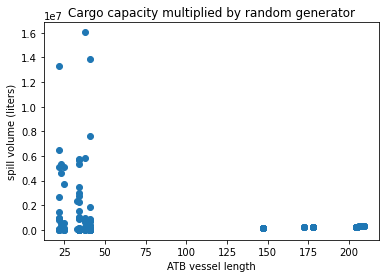

In [19]:
plt.scatter(spills_df_new[spills_df_new.vessel_type == 'atb'].vessel_len,
            spills_df_new[spills_df_new.vessel_type == 'atb'].spill_volume)
plt.ylabel('spill volume (liters)')
plt.xlabel('ATB vessel length')
plt.title('Cargo capacity multiplied by random generator')

#### Go fish!  Random generator obviously the same for all entries.  Resorting to for-loop

### Loop through each dataframe line and apply new random generator each time

In [20]:
for index, row in spills_df_new.iterrows():
    if (row['vessel_type'] == 'atb') & (row['vessel_len']>50):
        rnd = random_generator.choice(central_value, p=probability)
        spills_df_new.spill_volume[index] = row.cargo_capacity*rnd

/tmp/ipykernel_22151/3921574021.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spills_df_new.spill_volume[index] = row.cargo_capacity*rnd


Text(0.5, 1.0, 'Cargo capacity multiplied by random generator')

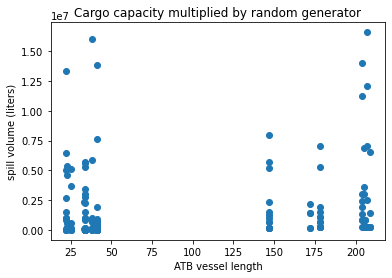

In [21]:
plt.scatter(spills_df_new[spills_df_new.vessel_type == 'atb'].vessel_len,
            spills_df_new[spills_df_new.vessel_type == 'atb'].spill_volume)
plt.ylabel('spill volume (liters)')
plt.xlabel('ATB vessel length')
plt.title('Cargo capacity multiplied by random generator')

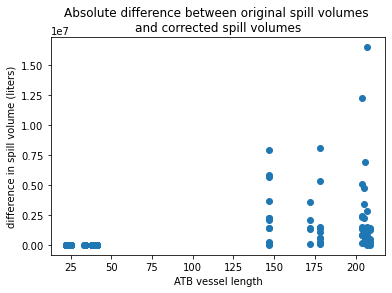

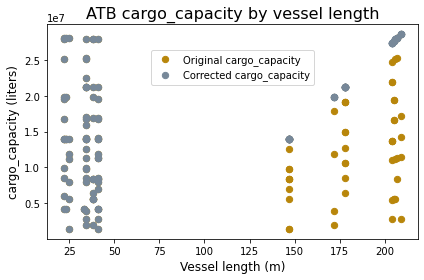

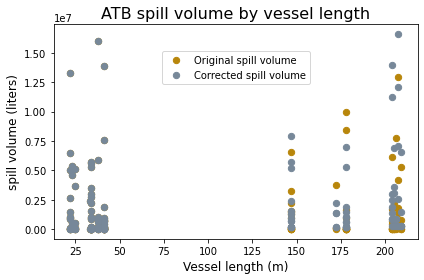

In [22]:
spill_diff = (spills_df[spills_df_new.vessel_type == 'atb'].spill_volume - 
    spills_df_new[spills_df_new.vessel_type == 'atb'].spill_volume)
plt.scatter(spills_df_new[spills_df_new.vessel_type == 'atb'].vessel_len,
            spill_diff.abs())
plt.ylabel('difference in spill volume (liters)')
plt.xlabel('ATB vessel length')
plt.title('Absolute difference between original spill volumes \nand corrected spill volumes')

# Compare original cargo capacities with corrected cargo capacities
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    spills_df[spills_df.vessel_type == 'atb'].vessel_len,
    spills_df[spills_df.vessel_type == 'atb'].cargo_capacity,
    40,
    label='Original cargo_capacity',
    color='darkgoldenrod'
)

ax1.scatter(
    spills_df_new[spills_df_new.vessel_type == 'atb'].vessel_len,
    spills_df_new[spills_df_new.vessel_type == 'atb'].cargo_capacity,
    40,
    label='Corrected cargo_capacity',
    color='lightslategrey'
)

plt.xlabel('Vessel length (m)',fontsize=12)
plt.ylabel('cargo_capacity (liters)',fontsize=12)
plt.title('ATB cargo_capacity by vessel length', fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(.5, .8), loc='center')
plt.show()

# Compare original spill volumes with corrected spill volumes
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    spills_df[spills_df.vessel_type == 'atb'].vessel_len,
    spills_df[spills_df.vessel_type == 'atb'].spill_volume,
    40,
    label='Original spill volume',
    color='darkgoldenrod'
)

ax1.scatter(
    spills_df_new[spills_df_new.vessel_type == 'atb'].vessel_len,
    spills_df_new[spills_df_new.vessel_type == 'atb'].spill_volume,
    40,
    label='Corrected spill volume',
    color='lightslategrey'
)

plt.xlabel('Vessel length (m)',fontsize=12)
plt.ylabel('spill volume (liters)',fontsize=12)
plt.title('ATB spill volume by vessel length', fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(.5, .8), loc='center')
plt.show()

### Save corrected spills file and ATB-only corrected spills file

In [23]:
[*oil_attrs]

['categories', 'directories', 'files', 'vessel_attributes']

In [24]:
[*oil_attrs['vessel_attributes']['atb']]

['cargo_capacity_bin_centers',
 'cargo_capacity_bins',
 'cargo_capacity_probability',
 'cargo_fill_fraction_bins',
 'cargo_fill_fraction_weights',
 'cargo_fit_coefs',
 'fuel_capacity_bin_centers',
 'fuel_capacity_bins',
 'fuel_capacity_probability',
 'fuel_fit_coefs',
 'max_cargo',
 'max_fuel',
 'max_length',
 'min_cargo',
 'min_fuel',
 'min_length',
 'probability_empty',
 'probability_full']

In [25]:
spills_df_new.head(2)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_BP
0,2018-02-03 22:00,7,-122.768738,48.858200,245,573,atb,209,366341000,BP Cherry Point Refinery,Chevron Stanovan,106150.674583,2.861345e+07,1.430673e+06,fuel,Lagrangian_bunker.dat,0.849564
1,2017-08-30 18:00,7,-122.763926,48.868556,244,574,barge,40,366866930,BP Cherry Point Refinery,BP Cherry Point Refinery,306160.614586,3.000000e+06,8.266337e+04,fuel,Lagrangian_bunker.dat,0.934545


In [26]:
spills_df_new.loc[spills_df_new['spill_volume'] ==0]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_BP


In [27]:
corrected_spills_file = spills
corrected_ATBspills_file = '/ocean/rmueller/MIDOSS/spill_files_091921/'\
         'chosen_for_monte_carlo/SalishSea_oil_spills_corrected_ATBonly_23mar2022.csv'
spills_df_new.to_csv(corrected_spills_file)
spills_df_new_atb =spills_df_new.loc[(spills_df_new.vessel_type == 'atb') & (spills_df_new.vessel_len > 50)] 
spills_df_new_atb.to_csv(corrected_ATBspills_file)

In [28]:
spills_df_new_atb.shape

(62, 17)

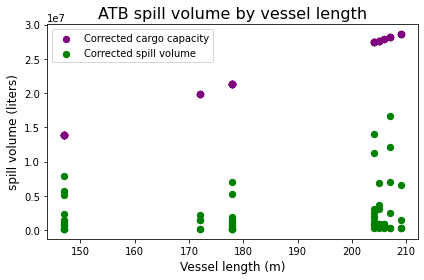

In [29]:
# Compare original spill volumes with corrected spill volumes
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    spills_df_new_atb.vessel_len,
    spills_df_new_atb.cargo_capacity,
    40,
    label='Corrected cargo capacity',
    color='purple'
)

ax1.scatter(
    spills_df_new_atb.vessel_len,
    spills_df_new_atb.spill_volume,
    40,
    label='Corrected spill volume',
    color='green'
)

plt.xlabel('Vessel length (m)',fontsize=12)
plt.ylabel('spill volume (liters)',fontsize=12)
plt.title('ATB spill volume by vessel length', fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0, 1), loc='upper left')
plt.show()

In [30]:
spills_df_new_atb.loc[
    spills_df_new_atb['cargo_capacity']<oil_attrs['vessel_attributes']['atb']['min_cargo']
]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_BP


In [31]:
print(f"The minimum, corrected cargo capacity is {spills_df_new_atb['cargo_capacity'].min():.2e}.")
print(f"The minimum threshold is {oil_attrs['vessel_attributes']['atb']['min_cargo']:.2e}.")

The minimum, corrected cargo capacity is 1.40e+07.
The minimum threshold is 4.00e+06.


In [32]:
spills_df_new_atb.loc[
    spills_df_new_atb['fuel_capacity']<3
]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_BP


### Check fuel capacities for corrected ATBs

In [33]:
corrected_ATBspills_file = '/ocean/rmueller/MIDOSS/spill_files_091921/'\
         'chosen_for_monte_carlo/SalishSea_oil_spills_corrected_ATBonly.csv'

In [34]:
ATB_df = pandas.read_csv(corrected_ATBspills_file,index_col=[0])

In [35]:
ATB_df.head(5)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_BP
0,2018-02-03 22:00,7,-122.768738,48.858200,245,573,atb,209,366341000,BP Cherry Point Refinery,Chevron Stanovan,106150.674583,2.861345e+07,2.002942e+06,fuel,Lagrangian_bunker.dat,0.849564
12,2016-04-08 21:00,7,-122.789864,48.864297,245,572,atb,204,338616000,NaN,NaN,275278.059452,2.743107e+07,1.014949e+07,cargo,Lagrangian_bunker.dat,2.357656
37,2017-03-08 23:00,7,-122.728907,48.814135,248,576,atb,172,369580000,Phillips 66 Ferndale Refinery,US,35515.148355,1.986382e+07,8.144165e+06,cargo,Lagrangian_gas.dat,5.640673
84,2018-08-03 01:00,7,-122.826177,48.754670,252,570,atb,178,368006870,Pacific,US,219740.175429,2.128268e+07,2.766748e+06,cargo,Lagrangian_bunker.dat,12.845519
138,2018-08-27 14:00,7,-122.727893,48.705966,255,576,atb,204,338616000,NaN,NaN,341862.895953,2.743107e+07,2.743107e+05,cargo,Lagrangian_bunker.dat,17.391744


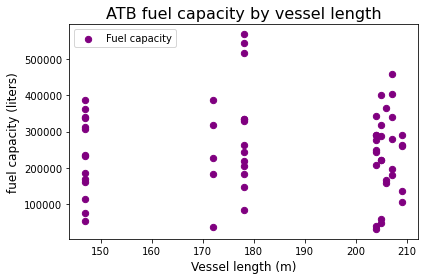

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    ATB_df.vessel_len,
    ATB_df.fuel_capacity,
    40,
    label='Fuel capacity',
    color='purple'
)
plt.xlabel('Vessel length (m)',fontsize=12)
plt.ylabel('fuel capacity (liters)',fontsize=12)
plt.title('ATB fuel capacity by vessel length', fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0, 1), loc='upper left')
plt.show()